In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
merged = pd.merge(transactions, customers, on="CustomerID")
merged = pd.merge(merged, products, on="ProductID")

In [4]:
customer_profile = merged.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Region": "first",
    "Category": lambda x: x.mode()[0]
}).reset_index()

In [5]:
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(customer_profile[["Region", "Category"]]).toarray()
encoded_feature_names = encoder.get_feature_names_out(["Region", "Category"])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

In [6]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_profile[["TotalValue", "Quantity"]])
scaled_df = pd.DataFrame(scaled_features, columns=["Scaled_TotalValue", "Scaled_Quantity"])

In [7]:
final_features = pd.concat([scaled_df, encoded_df], axis=1)
final_features["CustomerID"] = customer_profile["CustomerID"]

In [8]:
similarity_matrix = cosine_similarity(final_features.drop(columns=["CustomerID"]))

In [14]:
print(similarity_matrix.shape)
print(len(customer_ids))

(199, 199)
199


In [15]:
def recommend_lookalikes(similarity_matrix, customer_ids, top_n=3):
    recommendations = {}

    num_customers = len(customer_ids)

    for i, customer_id in enumerate(customer_ids):
        # Get similarity scores for the current customer
        scores = list(enumerate(similarity_matrix[i]))

        # Sort by similarity scores and exclude the customer itself
        scores = sorted(scores, key=lambda x: x[1], reverse=True)

        # Filter scores to only include valid indices
        scores = [(idx, score) for idx, score in scores if idx != i and idx < num_customers]

        # Take the top N similar customers
        top_scores = scores[:top_n]

        recommendations[customer_id] = [(customer_ids[idx], round(score, 4)) for idx, score in top_scores]

    return recommendations


In [17]:
customer_ids = customer_profile["CustomerID"].tolist()
top_lookalikes = recommend_lookalikes(similarity_matrix, customer_ids[:20])

In [18]:
import csv

# Save recommendations to a CSV file
with open("Lookalike.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["CustomerID", "Lookalikes"])

    for customer_id, lookalikes in top_lookalikes.items():
        lookalike_str = "; ".join([f"{cust_id} (Score: {score})" for cust_id, score in lookalikes])
        writer.writerow([customer_id, lookalike_str])

print("Lookalike recommendations saved to Lookalike.csv.")

Lookalike recommendations saved to Lookalike.csv.


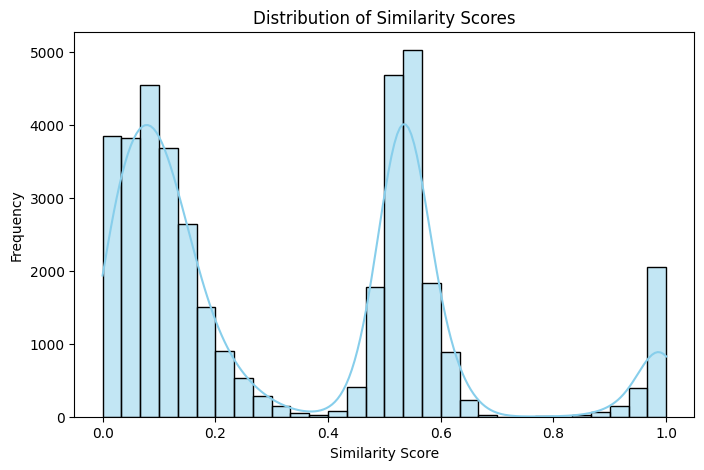

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

similarity_scores = similarity_matrix.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(similarity_scores, bins=30, kde=True, color="skyblue")
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()
